# Processing of the results

First some imports

In [3]:
import os

from gravann.input import csv_reader
from gravann.functions import unit_conversion

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ast
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Processing and Data Visualization

In [29]:
sample = "churyumov-gerasimenko"
output_directory = Path(f"./results/{sample}")
error_of_interest = "relRMSE"
input_csv_file = output_directory.joinpath(f"total_results_{sample}.csv")

noise_replacement = {
    "['']" : "No Noise",
    "['constant_bias', [0.000272, 0.0, 0.0]]": "Constant Bias $c = 0.000272$",
    "['gaussian', 0.0, 0.146731]": "Additive Gaussian $\mu = 0 \; \sigma= 0.14$",
    "['gaussian', 0.0, 1.467314]": "Additive Gaussian $\mu = 0 \; \sigma= 1.47$",
    "['adaptive_gaussian_noise', 0.001]": "Multiplicative Gaussian $\mu = 1 \; \sigma= 0.001$",
    "['adaptive_gaussian_noise', 0.01]": "Multiplicative Gaussian $\mu = 1 \; \sigma= 0.01$",
    "['adaptive_gaussian_noise', 0.1]": "Multiplicative Gaussian $\mu = 1 \; \sigma= 0.1$"
}

sample_distance_replacement = {
    "[0.0, 1.0]": "$(0, 1)$",
    "[1.0, 3.0]": "$(1, 3)$",
    "[3.0, 5.0]": "$(3, 5)$",
}

In [92]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.146731, [0.000272, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 1.467314, [0.000272, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["iterations"] == 10000) & (df["pretrained_model"] == "None") & (df["resolution"] == "100%") & (df["noise"] == "['']") & (df["sample_domain"] == "[0.0, 1.0]") & (df["integration_points"] == 300000)]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "pretrained_model", "seed", "resolution", "sample_domain", "noise"], inplace=True)

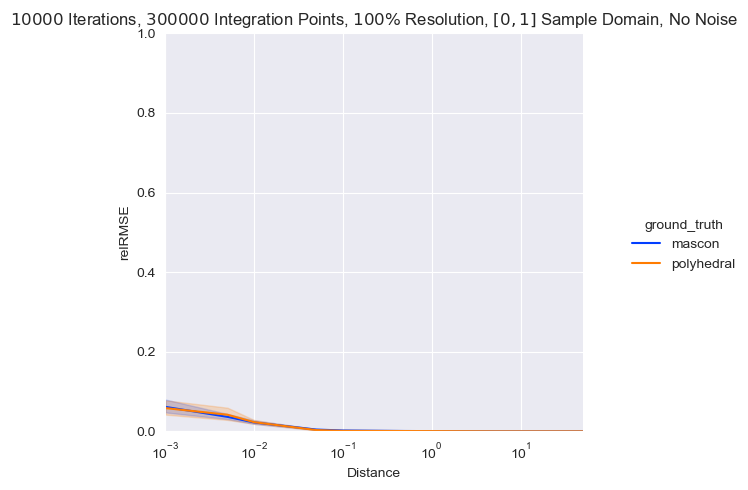

In [93]:
dfm = df.melt(["ground_truth"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

g = sns.relplot(
    data=dfm, kind="line",
    x="Distance", y=error_of_interest,
    hue="ground_truth", palette="bright"
)
g.set(
    xlim=(0.001, 50.0), xscale='log', ylim=(0.0, 1.0),
    title="$10 000$ Iterations, $300 000$ Integration Points, $100\%$ Resolution, $[0, 1]$ Sample Domain, No Noise"
)
g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_mascon_polyhedral.png")
g.savefig(save_path, dpi=300)

In [94]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.146731, [0.000272, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 1.467314, [0.000272, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["ground_truth"] == "polyhedral") & (df["resolution"] == "100%") & (df["noise"] == "['']") & (df["sample_domain"] == "[3.0, 5.0]") & (df["integration_points"] == 300000)]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "seed", "resolution", "sample_domain", "noise"], inplace=True)

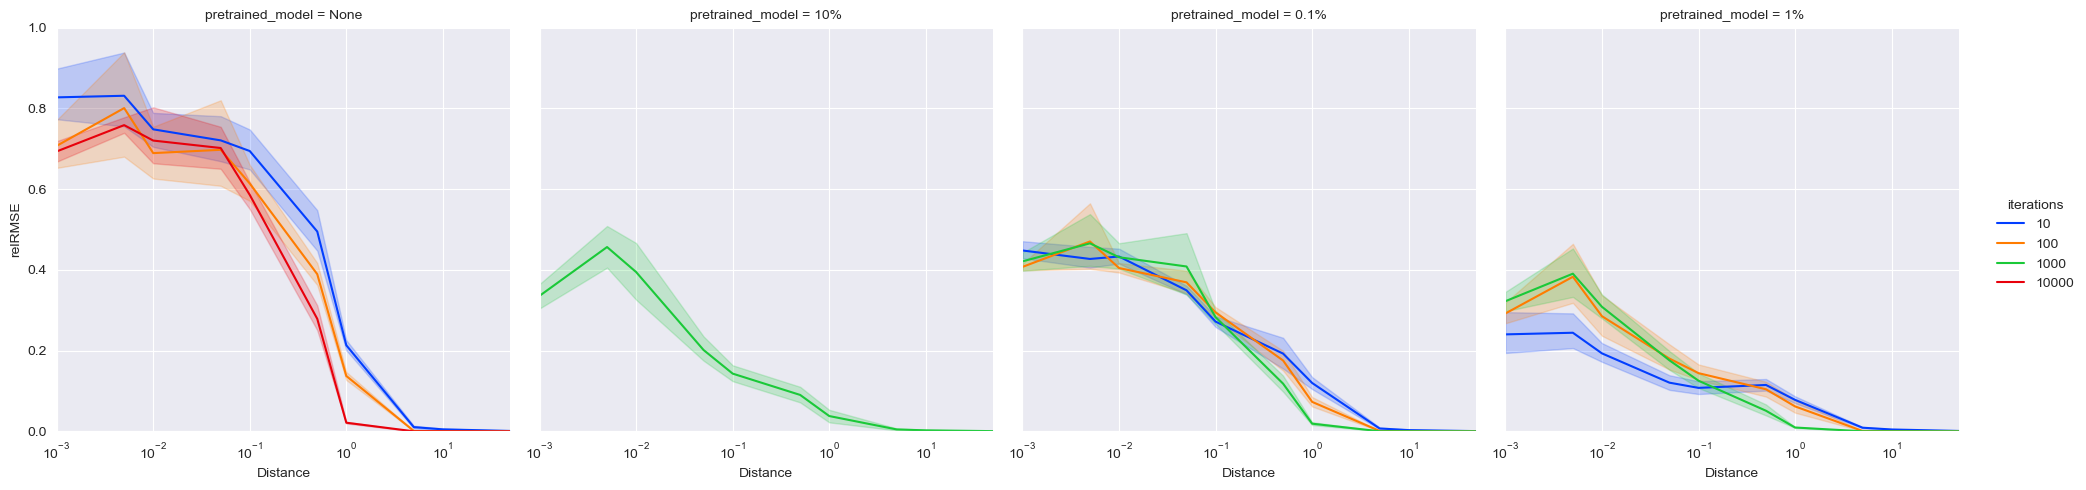

In [95]:
dfm = df.melt(["iterations", "pretrained_model"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

g = sns.relplot(
    data=dfm, kind="line",
    col="pretrained_model",
    x="Distance", y=error_of_interest,
    hue="iterations", palette="bright"
)
g.set(
    xlim=(0.001, 50.0), xscale='log', ylim=(0.0, 1.0),
)
g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_pretrain_iterations.png")
g.savefig(save_path, dpi=300)

In [111]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.146731, [0.000272, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 1.467314, [0.000272, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["ground_truth"] == "polyhedral") & (df["resolution"] == "100%") & (df["noise"] == "['']") & (df["pretrained_model"] == "None")]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "seed", "resolution", "noise", "ground_truth"], inplace=True)

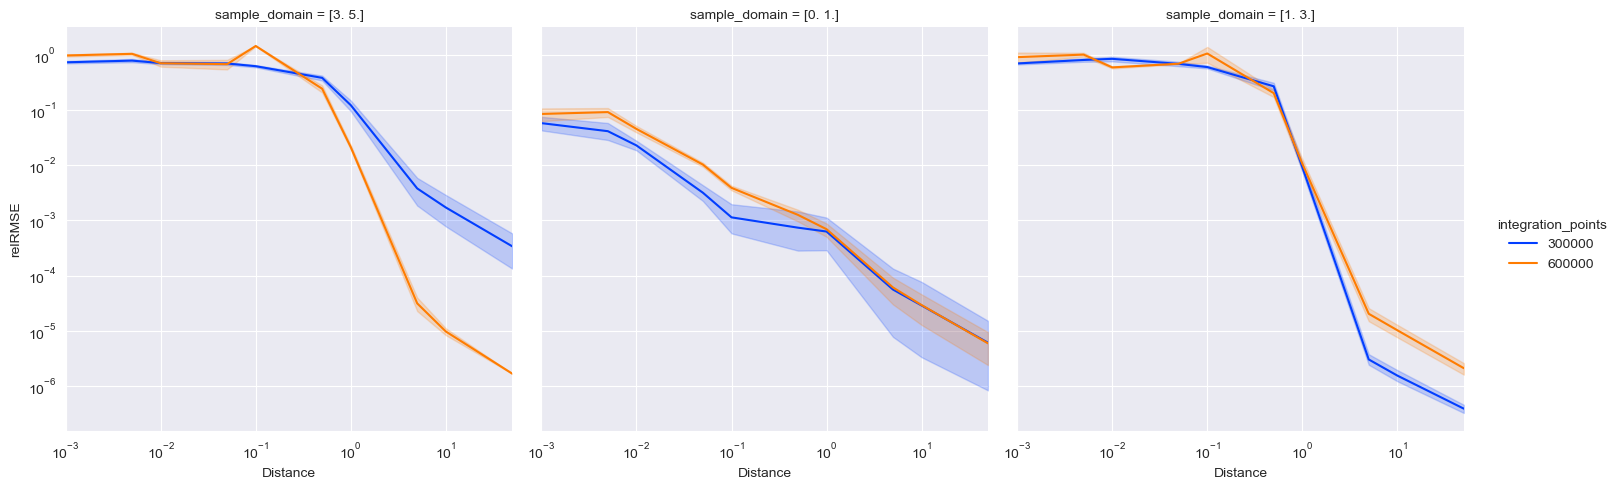

In [112]:
dfm = df.melt(["integration_points", "sample_domain"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["sample_domain"] = dfm["sample_domain"].apply(lambda x: str(x))
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

g = sns.relplot(
    data=dfm, kind="line",
    col="sample_domain",
    x="Distance", y=error_of_interest,
    hue="integration_points", palette="bright"
)
g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log'
)
g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_integration_points.png")
g.savefig(save_path, dpi=300)

In [113]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.146731, [0.000272, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 1.467314, [0.000272, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["iterations"] == 10000) & (df["pretrained_model"] == "None") & (df["resolution"] == "100%") & (df["integration_points"] == 300000) & (df["ground_truth"] == "polyhedral")]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "seed", "resolution", "ground_truth", "integration_points", "iterations"], inplace=True)

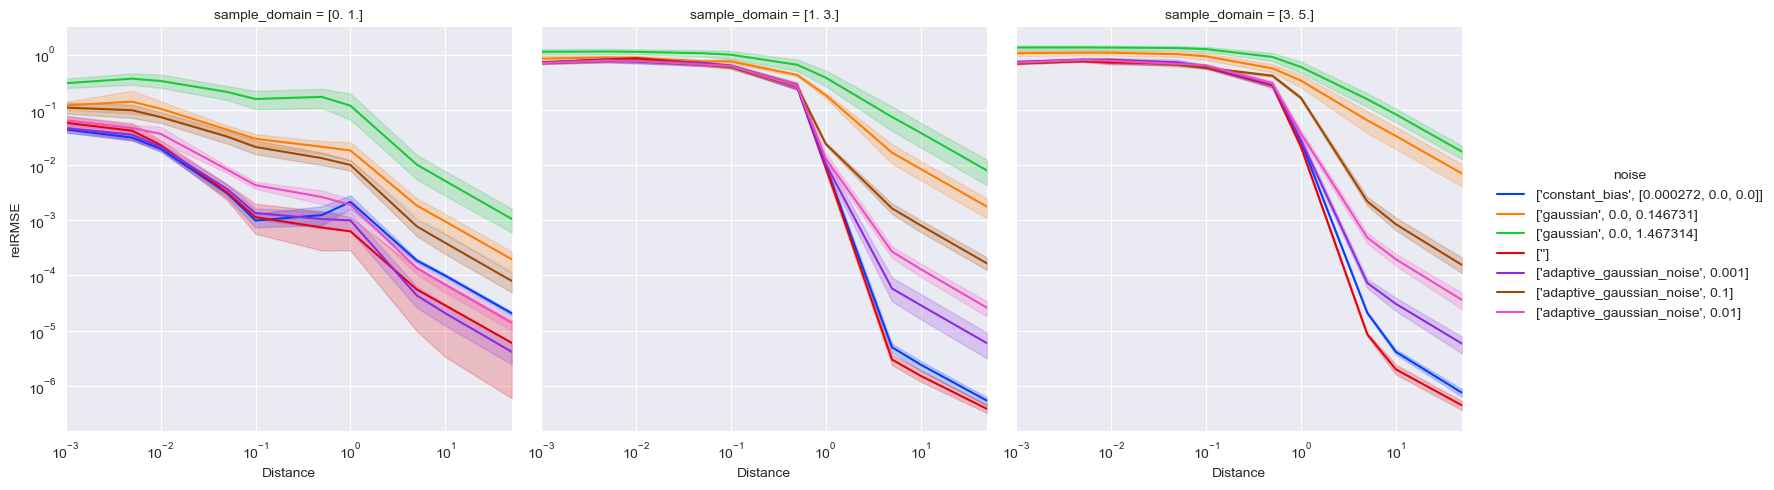

In [114]:
dfm = df.melt(["noise", "sample_domain"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["sample_domain"] = dfm["sample_domain"].apply(lambda x: str(x))
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

g = sns.relplot(
    data=dfm, kind="line",
    col="sample_domain",
    x="Distance", y=error_of_interest,
    hue="noise", palette="bright"
)
g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log'
)
g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_noise.png")
g.savefig(save_path, dpi=300)